# Data Exploration

In [1]:
# Starter code
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql.types import StringType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset
# event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
df = df.withColumn('timestamp', f.to_timestamp((df.ts/1000).cast(dataType=t.TimestampType())))
df = df.withColumn('date', f.to_date((df.ts/1000).cast(dataType=t.TimestampType())))

#create event table
df.createOrReplaceTempView("event_data")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1582438049660_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
import pandas as pd
import matplotlib.pyplot as plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)

In [5]:
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', timestamp=datetime.datetime(2018, 10, 1, 0, 0, 1), date=datetime.date(2018, 10, 1))

In [7]:
# Identify page
df_page_count = spark.sql('''
            select distinct page, count(*) as n_event
            from event_data
            group by 1
            order by 2
            ''').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

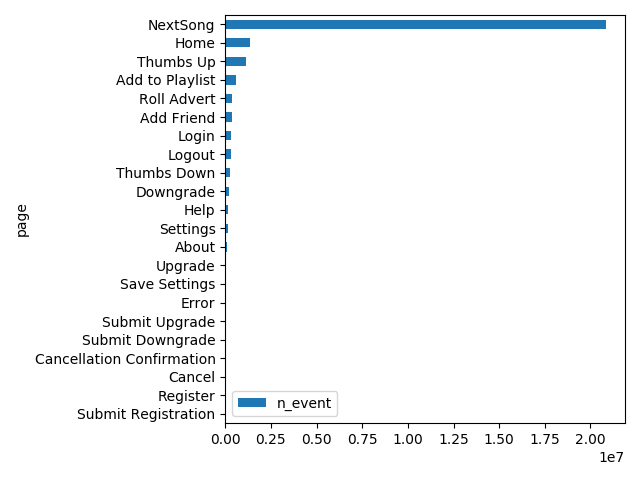

In [23]:
df_page_count.plot(x='page',kind='barh')
plt.tight_layout()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

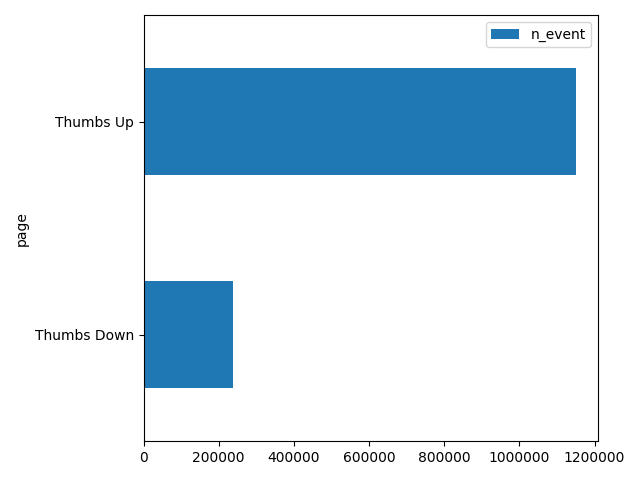

In [25]:
df_page_count[df_page_count['page'].isin(('Thumbs Up','Thumbs Down'))].plot(x='page',kind='barh')
plt.tight_layout()
%matplot plt

In [27]:
spark.sql('''
            select userId,artist,song,page,ts
            from event_data
            where page in ('Thumbs Up','Thumbs Down')
            ''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+----+-----------+-------------+
| userId|artist|song|       page|           ts|
+-------+------+----+-----------+-------------+
|1526624|  null|null|  Thumbs Up|1538352011000|
|1915980|  null|null|  Thumbs Up|1538352016000|
|1467665|  null|null|  Thumbs Up|1538352036000|
|1525594|  null|null|  Thumbs Up|1538352074000|
|1923638|  null|null|Thumbs Down|1538352083000|
|1059560|  null|null|Thumbs Down|1538352086000|
|1822046|  null|null|  Thumbs Up|1538352089000|
|1916157|  null|null|  Thumbs Up|1538352090000|
|1841647|  null|null|  Thumbs Up|1538352096000|
|1196855|  null|null|  Thumbs Up|1538352108000|
|1911021|  null|null|  Thumbs Up|1538352133000|
|1455101|  null|null|  Thumbs Up|1538352138000|
|1784351|  null|null|  Thumbs Up|1538352157000|
|1090733|  null|null|  Thumbs Up|1538352160000|
|1447418|  null|null|  Thumbs Up|1538352190000|
|1588246|  null|null|Thumbs Down|1538352224000|
|1689309|  null|null|  Thumbs Up|1538352234000|
|1682050|  null|null|  Thumbs Up|1538352

### Data Preprocessing
If we see from above, Thumbs Up data do not contain song value. Therefore we need some data preprocessing to capture the song value.

Next I found that the song value is exist in NextSong event before the Thumbs Up event.

In [29]:
spark.sql('''
            select userId,artist,song,page,ts
            from event_data
            where page in ('Thumbs Up','NextSong','Thumbs Down')
            and userId= '1526624'
            order by ts
            ''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+---------+-------------+
| userId|              artist|                song|     page|           ts|
+-------+--------------------+--------------------+---------+-------------+
|1526624|   Nortec Collective|      Olvidela Compa| NextSong|1538352010000|
|1526624|                null|                null|Thumbs Up|1538352011000|
|1526624|         The Killers|Smile Like You Me...| NextSong|1538352277000|
|1526624|        Marc Anthony|           Si Te Vas| NextSong|1538352661000|
|1526624|        Way Out West|     Northern Lights| NextSong|1538352947000|
|1526624|             50 Cent|                Heat| NextSong|1538353412000|
|1526624|        Rise Against|     Swing Life Away| NextSong|1538353666000|
|1526624|Carter The Unstop...|Growing Old Disgr...| NextSong|1538353866000|
|1526624|                null|                null|Thumbs Up|1538353867000|
|1526624|               Campo|             Perfume| NextSong|1538354060000|
|1526624|   

###### Utilising Lag Function
Following query is utilising the lag function in the sql to capture the song value in the event before Thumbs Up or Thumbs Down. From here I created new dataframe to keep only song, userid, and its value (1 for Thumbs Up, 0 for Thumbs Down)

In [30]:
df_rating = spark.sql('''
            with get_song_data as (
            select timestamp,artist, song, userId,page,
                lag( song,1) over (partition by userId order by timestamp) as lag_song,
                lag( artist,1) over (partition by userId order by timestamp) as lag_artist
            from event_data
            where page in ('NextSong','Thumbs Up','Thumbs Down','Add to Playlist')
            order by timestamp
            )
            select 
                    userId,
                    concat(lag_artist,'-',lag_song) as song,
        
                    min(
                    case when page = 'Thumbs Up' then 1.000 
                         when page = 'Thumbs Down' then 0
                    end )
                    as value
            from get_song_data
            where page in ('Thumbs Up','Thumbs Down')
                  and lag_song is not NULL
                  and lag_artist is not NULL
            group by 1,2
            order by 1,2
            ''')

df_rating.show()
df_rating.createOrReplaceTempView("dataset")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----+
| userId|                song|value|
+-------+--------------------+-----+
|1000025|    17 Hippies-Adieu|1.000|
|1000025|A Day To Remember...|1.000|
|1000025|A Rocket To The M...|0.000|
|1000025|Aaron Shust-Give ...|1.000|
|1000025|Afroman-Crazy Rap...|1.000|
|1000025|Air France-Windmi...|1.000|
|1000025|Alan Silvestri-Ou...|0.000|
|1000025|Alicia Keys-Un-th...|1.000|
|1000025|Alliance Ethnik-S...|1.000|
|1000025|Andres Calamaro-L...|1.000|
|1000025|  Andrew Bird-Effigy|1.000|
|1000025|B.o.B-Nothin' On ...|1.000|
|1000025|Barry Tuckwell/Ac...|1.000|
|1000025|Bellatrax feat. T...|1.000|
|1000025|     BeyoncÃÂ©-Halo|1.000|
|1000025|Big Drill Car-The...|1.000|
|1000025|Bitter Sweet-Suga...|1.000|
|1000025|  Bloc Party-Banquet|0.000|
|1000025|    Bo Diddley-Pills|1.000|
|1000025|Boys Noize-Shine ...|1.000|
+-------+--------------------+-----+
only showing top 20 rows

#### Statistics of User Ratings

In [32]:
spark.sql('''
    select count(distinct userId),count(distinct song)
    from dataset
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+--------------------+
|count(DISTINCT userId)|count(DISTINCT song)|
+----------------------+--------------------+
|                 21866|              151499|
+----------------------+--------------------+

In [36]:
spark.sql('''
    with count_rated_song as (
    select userId,count(song) as rated_song
    from dataset
    group by 1)
    select 
    avg(rated_song) as average_song_rated,
    min(rated_song)               as minimum_song_rated,
    approx_percentile(rated_song, 0.25, 100) as percentile_25,
    approx_percentile(rated_song, 0.50, 100) as percentile_50,
    approx_percentile(rated_song, 0.75, 100) as percentile_75,
    max(rated_song) as maximum_song_rated
    from count_rated_song
    
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+-------------+-------------+-------------+------------------+
|average_song_rated|minimum_song_rated|percentile_25|percentile_50|percentile_75|maximum_song_rated|
+------------------+------------------+-------------+-------------+-------------+------------------+
| 62.34674837647489|                 1|           15|           37|           92|               855|
+------------------+------------------+-------------+-------------+-------------+------------------+

In [37]:
spark.sql('''
    with count_rated_song as (
    select song,count(userId) as user_rating
    from dataset
    group by 1)
    select 
    avg(user_rating) as average_n_user_rating,
    min(user_rating)               as minimum_n_user_rating,
    approx_percentile(user_rating, 0.25, 100) as percentile_25,
    approx_percentile(user_rating, 0.50, 100) as percentile_50,
    approx_percentile(user_rating, 0.75, 100) as percentile_75,
    max(user_rating) as maximum_n_user_rating
    from count_rated_song
    
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+---------------------+-------------+-------------+-------------+---------------------+
|average_n_user_rating|minimum_n_user_rating|percentile_25|percentile_50|percentile_75|maximum_n_user_rating|
+---------------------+---------------------+-------------+-------------+-------------+---------------------+
|    8.998567647311203|                    1|            1|            2|            6|                 5137|
+---------------------+---------------------+-------------+-------------+-------------+---------------------+